<a href="https://colab.research.google.com/github/seungkyoon/Projects/blob/master/Bong_Seungkyoon_ps3_report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PSET 3
*CPSC 453: Unsupervised Learning*

*Seungkyoon Bong*

In [11]:
from google.colab import drive, files
drive.mount('/content/drive/')

%cd /content/drive/MyDrive/ColabNotebooks/
import sys
sys.path.append('/content/drive/MyDrive/ColabNotebooks/code')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/ColabNotebooks


In [18]:
from ps3_functions import *
from vae import VAE
import torch
from torchvision import datasets, transforms
import numpy as np
import torchvision.utils
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import time
from sklearn.neighbors import KernelDensity
from scipy.stats import entropy
from scipy.spatial.distance import cdist

# !pip install pyemd
# !pip install phate
# !pip install scprep
import phate
import scprep
from pyemd import emd

torch.manual_seed(1)

usage: ipykernel_launcher.py [-h] [--batch-size N] [--epochs N] [--no-cuda]
                             [--seed S] [--log-interval N]
ipykernel_launcher.py: error: unrecognized arguments: -f /root/.local/share/jupyter/runtime/kernel-b45c1edf-fe30-4936-b172-df8f0f437ace.json


SystemExit: ignored

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## 2 MNIST Classification

### 2.1 Downloading MNIST

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

mnist_train = datasets.MNIST(root = 'data', train=True, download=True, transform = transforms.ToTensor())
mnist_test = datasets.MNIST(root = 'data', train=False, download=True,transform = transforms.ToTensor())

batch_size = 128
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size, shuffle = True)

### 2.2 Logistic Regression

In [ ]:
model = LogisticRegression()
model = model.to(device)
SGD = torch.optim.SGD(model.parameters(), lr = 0.1)
loss_fn = torch.nn.CrossEntropyLoss()

train(model, loss_fn, SGD, train_loader, test_loader)
torch.save(model.state_dict(), '/content/drive/MyDrive/ColabNotebooks/log_reg.pt')

 EPOCH 10. Progress: 10.0%. 
 Train accuracy: 0.918233335018158. Test accuracy: 0.9202999472618103
 EPOCH 20. Progress: 20.0%. 
 Train accuracy: 0.92535001039505. Test accuracy: 0.9232999682426453
 EPOCH 30. Progress: 30.0%. 
 Train accuracy: 0.9279833436012268. Test accuracy: 0.9236999750137329
 EPOCH 40. Progress: 40.0%. 
 Train accuracy: 0.9288333654403687. Test accuracy: 0.9244999885559082
 EPOCH 50. Progress: 50.0%. 
 Train accuracy: 0.9300833344459534. Test accuracy: 0.9264000058174133
 EPOCH 60. Progress: 60.0%. 
 Train accuracy: 0.9306666851043701. Test accuracy: 0.9244999885559082
 EPOCH 70. Progress: 70.0%. 
 Train accuracy: 0.9312666654586792. Test accuracy: 0.925599992275238
 EPOCH 80. Progress: 80.0%. 
 Train accuracy: 0.9317666888237. Test accuracy: 0.926099956035614
 EPOCH 90. Progress: 90.0%. 
 Train accuracy: 0.9324666857719421. Test accuracy: 0.925599992275238
 EPOCH 100. Progress: 100.0%. 
 Train accuracy: 0.9331166744232178. Test accuracy: 0.9268999695777893


**Question 2.2.1:** *What percentage classification accuracy did your simple network achieve?*

**Answer:** After training for 100 epochs, my simple network achieved a test accuracy of ~92.7% (with a training accuracy of ~93.3%). This is quite impressive because the network is very simple with only a single layer of weights/biases connecting the inputs to outputs.


### 2.3 Feed-forward Neural Network

 EPOCH 10. Progress: 10.0%. 
 Train accuracy: 0.9260333180427551. Test accuracy: 0.9228999614715576
 EPOCH 20. Progress: 20.0%. 
 Train accuracy: 0.9298499822616577. Test accuracy: 0.9226999878883362
 EPOCH 30. Progress: 30.0%. 
 Train accuracy: 0.9322167038917542. Test accuracy: 0.9253000020980835
 EPOCH 40. Progress: 40.0%. 
 Train accuracy: 0.9334499835968018. Test accuracy: 0.9246000051498413
 EPOCH 50. Progress: 50.0%. 
 Train accuracy: 0.9340833425521851. Test accuracy: 0.924299955368042
 EPOCH 60. Progress: 60.0%. 
 Train accuracy: 0.9348000288009644. Test accuracy: 0.9261999726295471
 EPOCH 70. Progress: 70.0%. 
 Train accuracy: 0.9358500242233276. Test accuracy: 0.9253999590873718
 EPOCH 80. Progress: 80.0%. 
 Train accuracy: 0.935283362865448. Test accuracy: 0.9241999983787537
 EPOCH 90. Progress: 90.0%. 
 Train accuracy: 0.9361166954040527. Test accuracy: 0.9273999929428101
 EPOCH 100. Progress: 100.0%. 
 Train accuracy: 0.9363999962806702. Test accuracy: 0.924299955368042


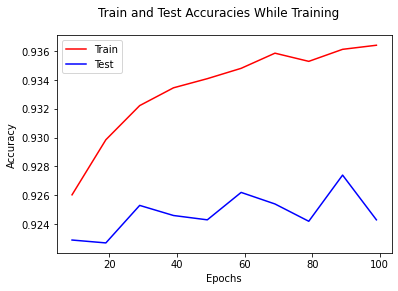

In [45]:
# Without non-linearity
model = FeedForwardNet()
model = model.to(device)
SGD = torch.optim.SGD(model.parameters(), lr = 0.05)
loss_fn = torch.nn.CrossEntropyLoss()

train(model, loss_fn, SGD, train_loader, test_loader)
torch.save(model.state_dict(), '/content/drive/MyDrive/ColabNotebooks/ff_nonlinear.pt')

 EPOCH 10. Progress: 10.0%. 
 Train accuracy: 0.8874666690826416. Test accuracy: 0.8955999612808228
 EPOCH 20. Progress: 20.0%. 
 Train accuracy: 0.9012500047683716. Test accuracy: 0.9083999991416931
 EPOCH 30. Progress: 30.0%. 
 Train accuracy: 0.9089666604995728. Test accuracy: 0.9139999747276306
 EPOCH 40. Progress: 40.0%. 
 Train accuracy: 0.9146833419799805. Test accuracy: 0.9185000061988831
 EPOCH 50. Progress: 50.0%. 
 Train accuracy: 0.9196000099182129. Test accuracy: 0.9231999516487122
 EPOCH 60. Progress: 60.0%. 
 Train accuracy: 0.9237333536148071. Test accuracy: 0.9261999726295471
 EPOCH 70. Progress: 70.0%. 
 Train accuracy: 0.9270833730697632. Test accuracy: 0.929099977016449
 EPOCH 80. Progress: 80.0%. 
 Train accuracy: 0.9296833276748657. Test accuracy: 0.930899977684021
 EPOCH 90. Progress: 90.0%. 
 Train accuracy: 0.9325166940689087. Test accuracy: 0.9317999482154846
 EPOCH 100. Progress: 100.0%. 
 Train accuracy: 0.9351500272750854. Test accuracy: 0.9339999556541443


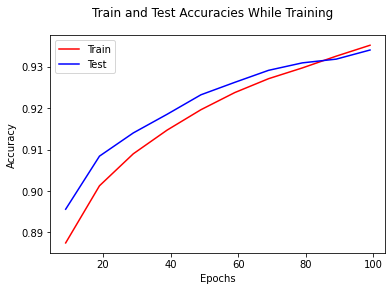

In [44]:
# With sigmoid non-linearity before and after
# Likely cripples the model to have a nonlinearity in output (because cross entropy loss already takes softmax)
model = FeedForwardNet(pre_activation = nn.Sigmoid(), post_activation = nn.Sigmoid())
model = model.to(device)
SGD = torch.optim.SGD(model.parameters(), lr = 0.1)
loss_fn = torch.nn.CrossEntropyLoss()

train(model, loss_fn, SGD, train_loader, test_loader)
torch.save(model.state_dict(), '/content/drive/MyDrive/ColabNotebooks/ff_sigmoid.pt')

 EPOCH 10. Progress: 10.0%. 
 Train accuracy: 0.9308666586875916. Test accuracy: 0.9325999617576599
 EPOCH 20. Progress: 20.0%. 
 Train accuracy: 0.949483335018158. Test accuracy: 0.9470999836921692
 EPOCH 30. Progress: 30.0%. 
 Train accuracy: 0.960266649723053. Test accuracy: 0.9563999772071838
 EPOCH 40. Progress: 40.0%. 
 Train accuracy: 0.9682833552360535. Test accuracy: 0.9624999761581421
 EPOCH 50. Progress: 50.0%. 
 Train accuracy: 0.974049985408783. Test accuracy: 0.9663999676704407
 EPOCH 60. Progress: 60.0%. 
 Train accuracy: 0.9780166745185852. Test accuracy: 0.9697999954223633
 EPOCH 70. Progress: 70.0%. 
 Train accuracy: 0.9811000227928162. Test accuracy: 0.9718999862670898
 EPOCH 80. Progress: 80.0%. 
 Train accuracy: 0.9835500121116638. Test accuracy: 0.9738999605178833
 EPOCH 90. Progress: 90.0%. 
 Train accuracy: 0.98580002784729. Test accuracy: 0.9746999740600586
 EPOCH 100. Progress: 100.0%. 
 Train accuracy: 0.9873499870300293. Test accuracy: 0.9761999845504761


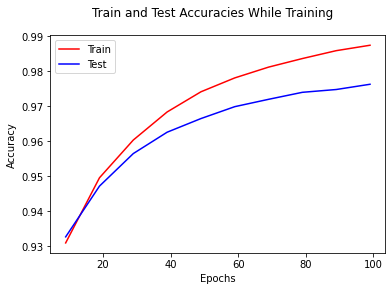

In [12]:
# With sigmoid non-linearity before
model = FeedForwardNet(pre_activation = nn.Sigmoid())
model = model.to(device)
SGD = torch.optim.SGD(model.parameters(), lr = 0.1)
loss_fn = torch.nn.CrossEntropyLoss()

train(model, loss_fn, SGD, train_loader, test_loader)
torch.save(model.state_dict(), '/content/drive/MyDrive/ColabNotebooks/ff_sigmoid_before.pt')

 EPOCH 10. Progress: 10.0%. 
 Train accuracy: 0.9794166684150696. Test accuracy: 0.9708999991416931
 EPOCH 20. Progress: 20.0%. 
 Train accuracy: 0.9902166724205017. Test accuracy: 0.9758999943733215
 EPOCH 30. Progress: 30.0%. 
 Train accuracy: 0.9945999979972839. Test accuracy: 0.9772999882698059
 EPOCH 40. Progress: 40.0%. 
 Train accuracy: 0.9970833659172058. Test accuracy: 0.9774999618530273
 EPOCH 50. Progress: 50.0%. 
 Train accuracy: 0.9986833333969116. Test accuracy: 0.9791999459266663
 EPOCH 60. Progress: 60.0%. 
 Train accuracy: 0.9994166493415833. Test accuracy: 0.9779999852180481
 EPOCH 70. Progress: 70.0%. 
 Train accuracy: 0.9996500015258789. Test accuracy: 0.9781999588012695
 EPOCH 80. Progress: 80.0%. 
 Train accuracy: 0.9998999834060669. Test accuracy: 0.9794999957084656
 EPOCH 90. Progress: 90.0%. 
 Train accuracy: 0.9999666810035706. Test accuracy: 0.9790999889373779
 EPOCH 100. Progress: 100.0%. 
 Train accuracy: 0.9999499917030334. Test accuracy: 0.979699969291687

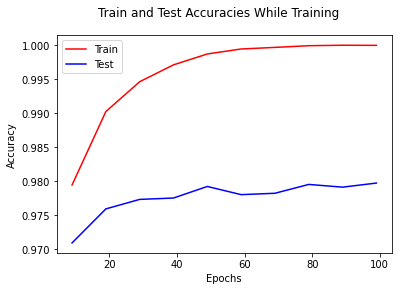

In [20]:
# With ReLU non-linearity before <- BEST MODEL
model = FeedForwardNet(pre_activation = nn.ReLU())
model = model.to(device)
SGD = torch.optim.SGD(model.parameters(), lr = 0.1)
loss_fn = torch.nn.CrossEntropyLoss()

train(model, loss_fn, SGD, train_loader, test_loader)
torch.save(model.state_dict(), '/content/drive/MyDrive/ColabNotebooks/ff_relu.pt')

 EPOCH 10. Progress: 10.0%. 
 Train accuracy: 0.9625000357627869. Test accuracy: 0.9587999582290649
 EPOCH 20. Progress: 20.0%. 
 Train accuracy: 0.9775500297546387. Test accuracy: 0.9723999500274658
 EPOCH 30. Progress: 30.0%. 
 Train accuracy: 0.9849500060081482. Test accuracy: 0.9751999974250793
 EPOCH 40. Progress: 40.0%. 
 Train accuracy: 0.9885666966438293. Test accuracy: 0.9757999777793884
 EPOCH 50. Progress: 50.0%. 
 Train accuracy: 0.9919500350952148. Test accuracy: 0.9768999814987183
 EPOCH 60. Progress: 60.0%. 
 Train accuracy: 0.9950000047683716. Test accuracy: 0.9782999753952026
 EPOCH 70. Progress: 70.0%. 
 Train accuracy: 0.9962166547775269. Test accuracy: 0.9784999489784241
 EPOCH 80. Progress: 80.0%. 
 Train accuracy: 0.9971666932106018. Test accuracy: 0.9785999655723572
 EPOCH 90. Progress: 90.0%. 
 Train accuracy: 0.9983167052268982. Test accuracy: 0.9788999557495117
 EPOCH 100. Progress: 100.0%. 
 Train accuracy: 0.9990666508674622. Test accuracy: 0.978899955749511

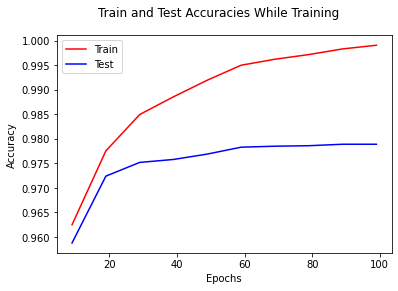

In [21]:
# With Softplus non-linearity before
model = FeedForwardNet(pre_activation = nn.Softplus())
model = model.to(device)
SGD = torch.optim.SGD(model.parameters(), lr = 0.1)
loss_fn = torch.nn.CrossEntropyLoss()

train(model, loss_fn, SGD, train_loader, test_loader)
torch.save(model.state_dict(), '/content/drive/MyDrive/ColabNotebooks/ff_softplus.pt')

 EPOCH 10. Progress: 10.0%. 
 Train accuracy: 0.9606000185012817. Test accuracy: 0.9533999562263489
 EPOCH 20. Progress: 20.0%. 
 Train accuracy: 0.9720500111579895. Test accuracy: 0.9634999632835388
 EPOCH 30. Progress: 30.0%. 
 Train accuracy: 0.977649986743927. Test accuracy: 0.9651999473571777
 EPOCH 40. Progress: 40.0%. 
 Train accuracy: 0.9832000136375427. Test accuracy: 0.9690999984741211
 EPOCH 50. Progress: 50.0%. 
 Train accuracy: 0.985883355140686. Test accuracy: 0.9703999757766724
 EPOCH 60. Progress: 60.0%. 
 Train accuracy: 0.9874666929244995. Test accuracy: 0.9698999524116516
 EPOCH 70. Progress: 70.0%. 
 Train accuracy: 0.9901833534240723. Test accuracy: 0.9697999954223633
 EPOCH 80. Progress: 80.0%. 
 Train accuracy: 0.9922333359718323. Test accuracy: 0.9699999690055847
 EPOCH 90. Progress: 90.0%. 
 Train accuracy: 0.9932000041007996. Test accuracy: 0.9684999585151672
 EPOCH 100. Progress: 100.0%. 
 Train accuracy: 0.9953333735466003. Test accuracy: 0.9698999524116516


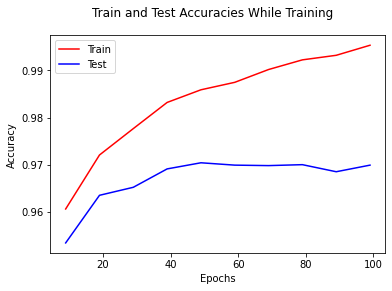

In [22]:
# Best activation function (ReLU) non-linearity with smaller hidden size
model = FeedForwardNet(hidden_size = 30, pre_activation = nn.ReLU())
model = model.to(device)
SGD = torch.optim.SGD(model.parameters(), lr = 0.1)
loss_fn = torch.nn.CrossEntropyLoss()

train(model, loss_fn, SGD, train_loader, test_loader)
torch.save(model.state_dict(), '/content/drive/MyDrive/ColabNotebooks/ff_narrow.pt')

 EPOCH 10. Progress: 10.0%. 
 Train accuracy: 0.928600013256073. Test accuracy: 0.9305999875068665
 EPOCH 20. Progress: 20.0%. 
 Train accuracy: 0.9451666474342346. Test accuracy: 0.9448999762535095
 EPOCH 30. Progress: 30.0%. 
 Train accuracy: 0.9542833566665649. Test accuracy: 0.9524999856948853
 EPOCH 40. Progress: 40.0%. 
 Train accuracy: 0.9612166881561279. Test accuracy: 0.9580000042915344
 EPOCH 50. Progress: 50.0%. 
 Train accuracy: 0.9667500257492065. Test accuracy: 0.962399959564209
 EPOCH 60. Progress: 60.0%. 
 Train accuracy: 0.9702333211898804. Test accuracy: 0.965499997138977
 EPOCH 70. Progress: 70.0%. 
 Train accuracy: 0.9735167026519775. Test accuracy: 0.9680999517440796
 EPOCH 80. Progress: 80.0%. 
 Train accuracy: 0.9761000275611877. Test accuracy: 0.9693999886512756
 EPOCH 90. Progress: 90.0%. 
 Train accuracy: 0.9783833622932434. Test accuracy: 0.9715999960899353
 EPOCH 100. Progress: 100.0%. 
 Train accuracy: 0.9806666970252991. Test accuracy: 0.972599983215332


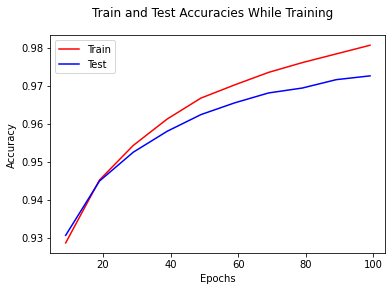

In [23]:
# Best activation function (ReLU) non-linearity with lower learning rate
model = FeedForwardNet(pre_activation = nn.ReLU())
model = model.to(device)
SGD = torch.optim.SGD(model.parameters(), lr = 0.01)
loss_fn = torch.nn.CrossEntropyLoss()

train(model, loss_fn, SGD, train_loader, test_loader)
torch.save(model.state_dict(), '/content/drive/MyDrive/ColabNotebooks/ff_lr.pt')

 EPOCH 10. Progress: 10.0%. 
 Train accuracy: 0.9958166480064392. Test accuracy: 0.9792999625205994
 EPOCH 20. Progress: 20.0%. 
 Train accuracy: 0.994616687297821. Test accuracy: 0.9768999814987183
 EPOCH 30. Progress: 30.0%. 
 Train accuracy: 0.9963499903678894. Test accuracy: 0.9754999876022339
 EPOCH 40. Progress: 40.0%. 
 Train accuracy: 0.9980166554450989. Test accuracy: 0.9782999753952026
 EPOCH 50. Progress: 50.0%. 
 Train accuracy: 0.9970000386238098. Test accuracy: 0.975600004196167
 EPOCH 60. Progress: 60.0%. 
 Train accuracy: 0.9988999962806702. Test accuracy: 0.979699969291687
 EPOCH 70. Progress: 70.0%. 
 Train accuracy: 0.9987333416938782. Test accuracy: 0.9768999814987183
 EPOCH 80. Progress: 80.0%. 
 Train accuracy: 0.9987666606903076. Test accuracy: 0.9782999753952026
 EPOCH 90. Progress: 90.0%. 
 Train accuracy: 0.9988999962806702. Test accuracy: 0.9788999557495117
 EPOCH 100. Progress: 100.0%. 
 Train accuracy: 0.9987500309944153. Test accuracy: 0.9795999526977539


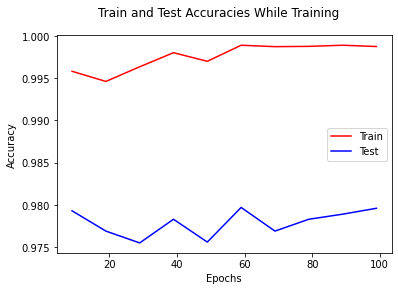

In [43]:
# Best activation function (ReLU) non-linearity with Adam Optimizer
model = FeedForwardNet(pre_activation = nn.ReLU())
model = model.to(device)
Adam = torch.optim.Adam(model.parameters(), lr = 0.005)
loss_fn = torch.nn.CrossEntropyLoss()

train(model, loss_fn, Adam, train_loader, test_loader)
torch.save(model.state_dict(), '/content/drive/MyDrive/ColabNotebooks/ff_adam.pt')

In [39]:
# Confusion Matrix for Best Model (ReLU)
from sklearn.metrics import confusion_matrix

classifier = FeedForwardNet(pre_activation = nn.ReLU()).to(device)
classifier.load_state_dict(torch.load('/content/drive/MyDrive/ColabNotebooks/ff_relu.pt'))
classifier.eval()

all_targets = []
all_outs = []
for data, targets in train_loader:
    targets = targets.to(device)
    model_input = torch.reshape(data, (-1, 784)).to(device)
    outs = classifier(model_input).argmax(dim=1).flatten()

    all_targets.extend(targets)
    all_outs.extend(outs)

for data, targets in test_loader:
    targets = targets.to(device)
    model_input = torch.reshape(data, (-1, 784)).to(device)
    outs = classifier(model_input).argmax(dim=1).flatten()

    all_targets.extend(targets)
    all_outs.extend(outs)

all_targets = list(map(int, all_targets))
all_outs = list(map(int, all_outs))
cm = confusion_matrix(all_targets, all_outs)
print(cm)

[[6896    0    2    0    0    0    1    1    2    1]
 [   0 7865    3    2    0    1    2    2    2    0]
 [   3    1 6969    2    2    0    4    4    5    0]
 [   0    0    7 7113    1    8    0    5    1    6]
 [   0    0    4    0 6805    0    3    3    1    8]
 [   4    0    0    6    1 6286    8    1    3    4]
 [   2    3    1    1    6    5 6855    1    2    0]
 [   1    4    4    4    1    0    0 7270    4    5]
 [   4    0    1    5    3    0    4    4 6800    4]
 [   3    2    0    4    7    2    0    3    2 6935]]


Activation (Before Hidden Layer) | Activation (After Hidden Layer) | LR | Optimizer | Hidden Size | Train Accuracy | Test Accuracy
--- | --- | --- | --- | --- | --- | ---
Linear (Identity) | Linear (Identity) | 0.01 | SGD | 128 | 93.26% | 0.9248
Sigmoid | Sigmoid | 0.1 | SGD | 128 |
Sigmoid | Linear (Identity) | 0.1 | SGD | 128 |
ReLU | Linear (Identity) | 0.1 | SGD | 128 |
Softplus | Linear (Identity) | 0.1 | SGD | 128 |
ReLU | Linear (Identity) | 0.1 | SGD | 30 |
ReLU | Linear (Identity) | 0.01 | SGD | 128 |
ReLU | Linear (Identity) | 0.001 | Adam | 128 |

**Question 2.3.1:** *What percentage classification accuracy does this more complex network achieve?*

**Answer:** 

**Question 2.3.2:** *Create a plot of the training and test error vs the number of iterations. How many iterations
are sufficient to reach good performance?*

**Answer:** 

**Question 2.3.3:** *Print the confusion matrix showing which digits were misclassified, and what they were misclassified as. What numbers are frequently confused with one another by your model?*

**Answer:** 

**Question 2.3.4:** *Experiment with the learning rate, optimizer and activation function of your network. Report the best accuracy and briefly describe the training scheme that reached this accuracy.*

**Answer:** Also, I am assuming optimizer is supposed to be width of hidden layer because that is what was asked in the coding directions.

Nonlinear activation functions are preferred as they allow the nodes to learn more complex structures in the data.

## 3 Autoencoder

### 3.1 MNIST

In [ ]:
def train(model, loss_fn, optimizer, train_loader, test_loader):
    """
    This is a standard training loop, which leaves some parts to be filled in.
    INPUT:
    :param model: an untrained pytorch model
    :param loss_fn: e.g. Cross Entropy loss of Mean Squared Error.
    :param optimizer: the model optimizer, initialized with a learning rate.
    :param training_set: The training data, in a dataloader for easy iteration.
    :param test_loader: The testing data, in a dataloader for easy iteration.
    """
    num_epochs = 100 # obviously, this is too many. I don't know what this author was thinking.
    for epoch in range(num_epochs):
        # loop through each data point in the training set
        for data, targets in train_loader:

            # run the model on the data
            model_input = torch.reshape(data, (-1, 784)).to(device)
            out = model(model_input)

            # Calculate the loss
            loss = loss_fn(out, model_input)

            # Find the gradients of our loss via backpropogation
            loss.backward()

            # Adjust accordingly with the optimizer
            optimizer.step()
            optimizer.zero_grad()

        # Give status reports every 5 epochs
        if (epoch + 1) % 5==0:
            print(f" EPOCH {epoch+1}. Progress: {(epoch+1)/num_epochs*100}%. ")
            print(f" Train loss: {evaluate(model,train_loader)}. Test loss: {evaluate(model,test_loader)}")

def evaluate(model, evaluation_set):
    """
    Evaluates the given model on the given dataset.
    Returns the MSE loss of the output and original input
    """
    total_loss = 0
    total_samples = 0
    loss_fn = torch.nn.MSELoss()

    with torch.no_grad():
        for data, targets in evaluation_set:

            model_input = torch.reshape(data, (-1, 784)).to(device)
            out = model(model_input)

            total_samples += targets.shape[0]
            total_loss += loss_fn(out, model_input)*targets.shape[0]

    mean_loss = 1.0 * total_loss / total_samples
    return mean_loss

In [ ]:
model = Autoencoder(activation = nn.Tanh())
model = model.to(device)
Adam = torch.optim.Adam(model.parameters(), lr = 1e-3)
loss_fn = torch.nn.MSELoss()

train(model, loss_fn, Adam, train_loader, test_loader)
torch.save(model.state_dict(), '/content/drive/MyDrive/ColabNotebooks/ae_tanh.pt')

 EPOCH 5. Progress: 5.0%. 
 Train loss: 0.03971928358078003. Test loss: 0.039753977209329605
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.03825227543711662. Test loss: 0.03825204819440842
 EPOCH 15. Progress: 15.0%. 
 Train loss: 0.03697613999247551. Test loss: 0.03711700811982155
 EPOCH 20. Progress: 20.0%. 
 Train loss: 0.03632295876741409. Test loss: 0.03646008297801018
 EPOCH 25. Progress: 25.0%. 
 Train loss: 0.035278987139463425. Test loss: 0.03563898056745529
 EPOCH 30. Progress: 30.0%. 
 Train loss: 0.03516751900315285. Test loss: 0.03558137267827988
 EPOCH 35. Progress: 35.0%. 
 Train loss: 0.03494458273053169. Test loss: 0.03547857701778412
 EPOCH 40. Progress: 40.0%. 
 Train loss: 0.03503577411174774. Test loss: 0.03564044088125229
 EPOCH 45. Progress: 45.0%. 
 Train loss: 0.03483179211616516. Test loss: 0.03520921617746353
 EPOCH 50. Progress: 50.0%. 
 Train loss: 0.03463738411664963. Test loss: 0.03501656651496887
 EPOCH 55. Progress: 55.00000000000001%. 
 Train loss: 0.034

In [8]:
def display_1000(model, out_size = 2, extra_hidden = None, extra_targets = None):
    all_outs = np.empty((0, out_size))
    all_targets = []

    total_displayed = 0
    for data, targets in test_loader:
      model_input = torch.reshape(data, (-1, 784))
      
      if model.__class__.__name__ == "VAE":
          out = model.encode(model_input)[0].detach().numpy()
      else:
          out = model.encode(model_input).detach().numpy()

      all_outs = np.vstack((all_outs, out))
      all_targets.extend(list(map(int, targets)))
      
      total_displayed += targets.shape[0]
      if total_displayed >= 1000:
        break

    outs = all_outs
    if model.__class__.__name__ == "VAE":
        phate_op = phate.PHATE(verbose=0)
        outs = phate_op.fit_transform(all_outs)
        if (extra_hidden is not None and extra_targets is not None):
            extra_hidden = phate_op.transform(extra_hidden)

    ax = scprep.plot.scatter2d(outs, c = all_targets, legend = True, legend_loc = 'right', discrete=True,
                          figsize=(12, 8), cmap=scprep.plot.colors.tab10_continuous(n_colors=10))
    ax.set_title("Embedding Layer of Autoencoder for 1000 Images")
    
    if extra_hidden is not None and extra_targets is not None:
      ax.scatter(extra_hidden[0:2, 0], extra_hidden[0:2, 1], c=extra_targets, marker='x',
                s=300, cmap=scprep.plot.colors.tab10_continuous(n_colors=10),
                          vmin=0, vmax=9)
      ax.scatter(extra_hidden[2, 0], extra_hidden[2, 1], c='red', marker='x', s=300)
      ax.set_title(f"Plot with Interpolated {extra_targets[0]}-{extra_targets[1]} In Red")
  

def display_10(model):
  total_displayed = [False]*10
  plt.figure(figsize=(20, 4))
  for data, targets in test_loader:
    model_input = torch.reshape(data, (-1, 784))

    if model.__class__.__name__ == "VAE":
        out = model(model_input)[0].detach().numpy()
    else:
        out = model(model_input).detach().numpy()
    out = out.reshape(-1, 28, 28)

    for i, target in enumerate(targets):
      if not total_displayed[target]:
        plt.subplot(2, 10, target + 1)
        plt.axis('off')
        plt.imshow(data[i, :, :].reshape(28, 28), aspect='auto')

        plt.subplot(2, 10, target + 11)
        plt.axis('off')
        plt.imshow(out[i, :, :].reshape(28, 28), aspect='auto')

        total_displayed[target] = True
    
    if not any(total_displayed):
      break
    
  plt.show()

def interpolate(model):
  plt.figure(figsize=(12, 4))
  for data, targets in test_loader:
    if targets[0] == targets[[1]]: continue
    model_input = torch.reshape(data[0:2, :, :], (-1, 784))
    out = model.encode(model_input)
    if model.__class__.__name__ == "VAE":
        mu, logvar = out
    
    plt.subplot(1, 3, 1)
    plt.axis('off')
    plt.title(f'Original {targets[0]}')
    plt.imshow(data[0, :, :].reshape(28, 28), aspect = 'auto')

    plt.subplot(1, 3, 3)
    plt.axis('off')
    plt.title(f'Original {targets[1]}')
    plt.imshow(data[1, :, :].reshape(28, 28), aspect = 'auto')
    
    if model.__class__.__name__ == "VAE":
        mu_mean = mu.mean(dim=0)
        logvar_mean = logvar.mean(dim=0)
        interpolated = model.reparameterize(mu_mean, logvar_mean)
    else:
        interpolated = out.mean(dim=0)

    output = model.decode(interpolated).detach().numpy().reshape(28, 28)
    plt.subplot(1, 3, 2)
    plt.axis('off')
    plt.title(f'Interpolated {targets[0]}-{targets[1]}')
    plt.imshow(output, aspect = 'auto')

    break

  plt.show()

  targets = [targets[0], targets[1]]
  if model.__class__.__name__ == "VAE":
      out = torch.vstack((mu, mu_mean)).detach().numpy()
  else:
      out = torch.vstack((out, interpolated)).detach().numpy()

  display_1000(model, out_size = out.shape[1], extra_hidden = out, extra_targets = targets)


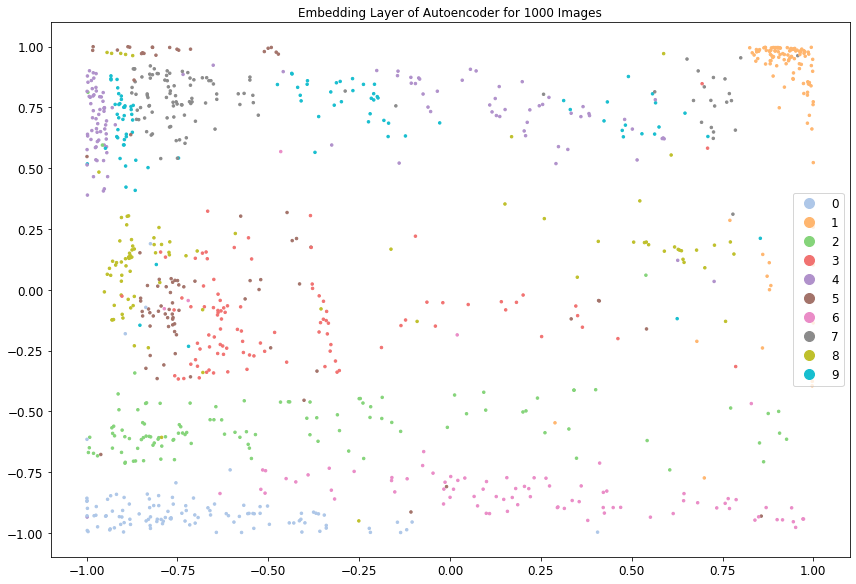

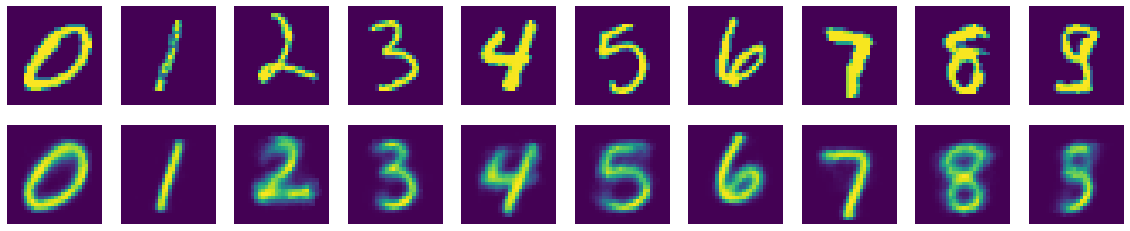

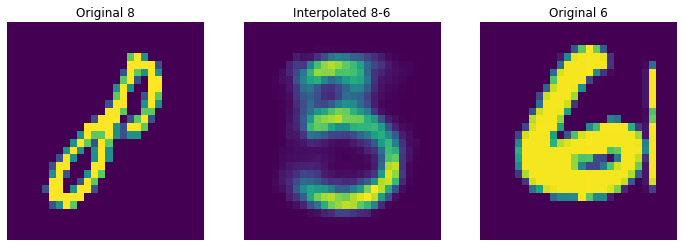

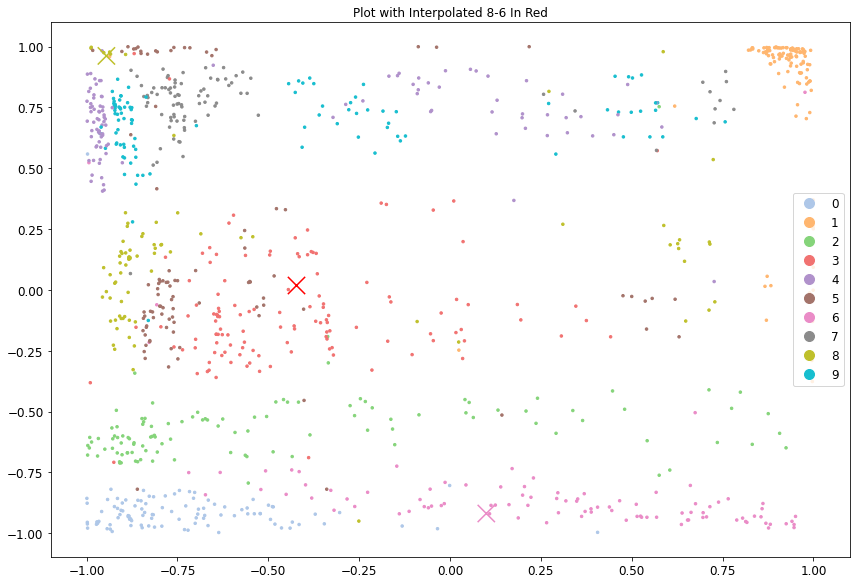

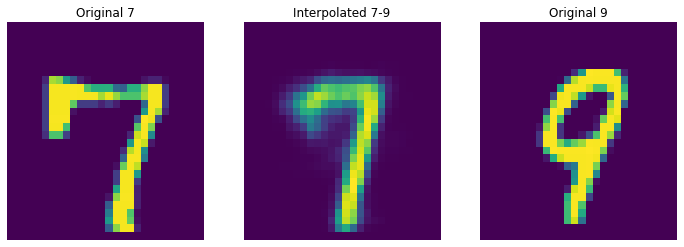

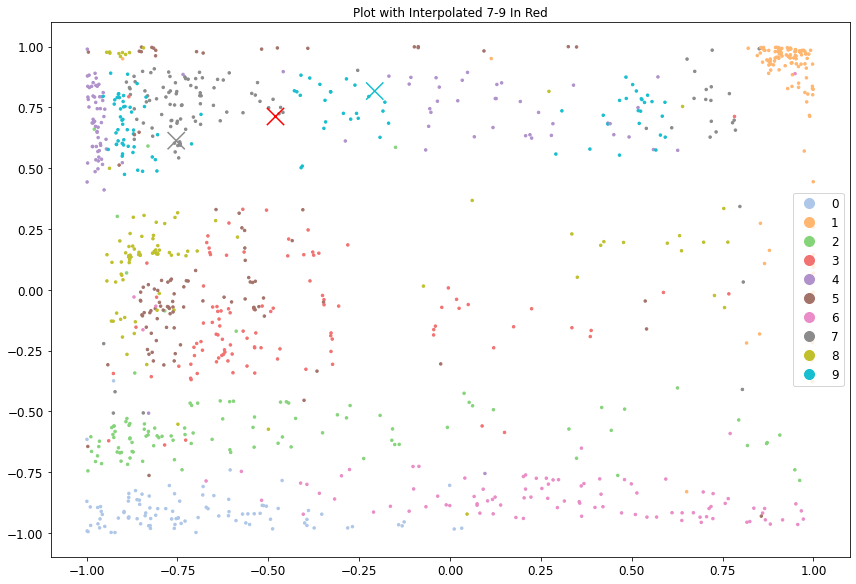

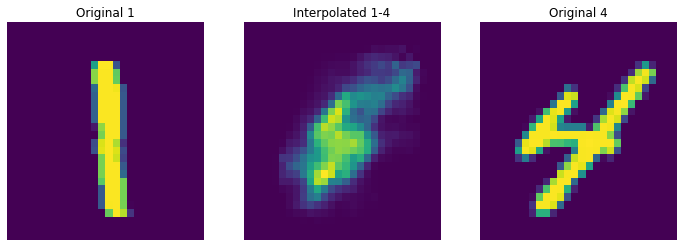

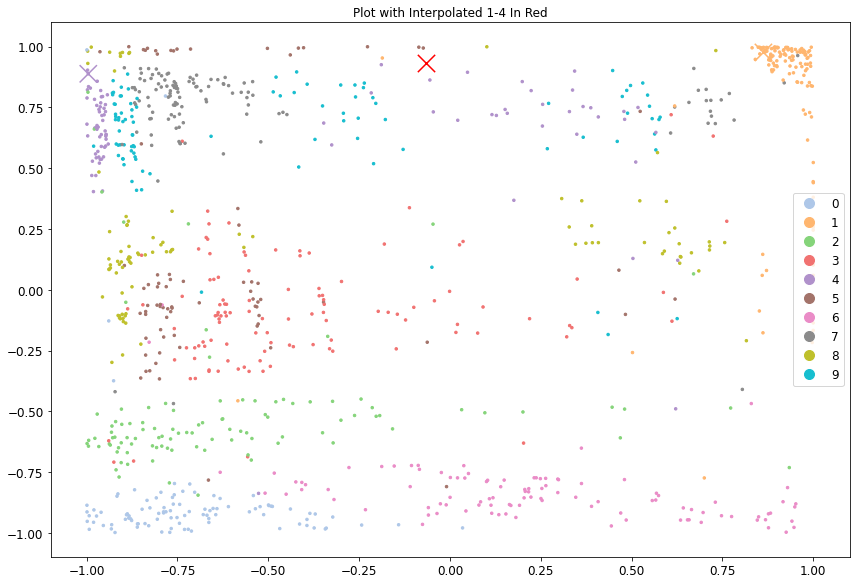

In [ ]:
model = Autoencoder(activation = nn.Tanh())
model.load_state_dict(torch.load('/content/drive/MyDrive/ColabNotebooks/ae_tanh.pt'))
model.eval()

display_1000(model)
display_10(model)

for i in range(3):
  interpolate(model)

In [ ]:
model = Autoencoder()
model = model.to(device)
Adam = torch.optim.Adam(model.parameters(), lr = 1e-3)
loss_fn = torch.nn.MSELoss()

train(model, loss_fn, Adam, train_loader, test_loader)
torch.save(model.state_dict(), '/content/drive/MyDrive/ColabNotebooks/ae_identity.pt')

 EPOCH 5. Progress: 5.0%. 
 Train loss: 0.03961634635925293. Test loss: 0.0399719662964344
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.036376673728227615. Test loss: 0.037006065249443054
 EPOCH 15. Progress: 15.0%. 
 Train loss: 0.035099174827337265. Test loss: 0.035776104778051376
 EPOCH 20. Progress: 20.0%. 
 Train loss: 0.03458607196807861. Test loss: 0.03539487347006798
 EPOCH 25. Progress: 25.0%. 
 Train loss: 0.034379735589027405. Test loss: 0.035191748291254044
 EPOCH 30. Progress: 30.0%. 
 Train loss: 0.033789992332458496. Test loss: 0.034768685698509216
 EPOCH 35. Progress: 35.0%. 
 Train loss: 0.033441927284002304. Test loss: 0.03448091819882393
 EPOCH 40. Progress: 40.0%. 
 Train loss: 0.032894037663936615. Test loss: 0.03393232822418213
 EPOCH 45. Progress: 45.0%. 
 Train loss: 0.03251643851399422. Test loss: 0.03377606347203255
 EPOCH 50. Progress: 50.0%. 
 Train loss: 0.032349176704883575. Test loss: 0.03374491631984711
 EPOCH 55. Progress: 55.00000000000001%. 
 Train los

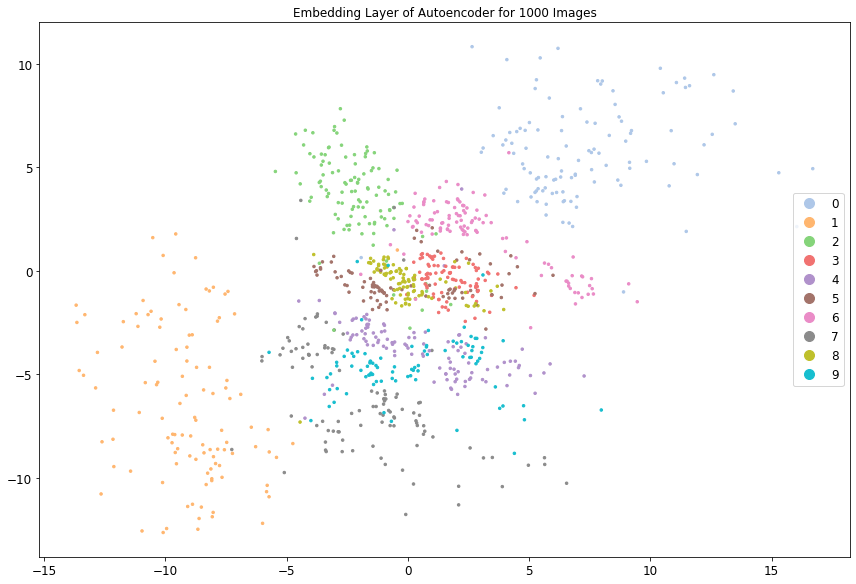

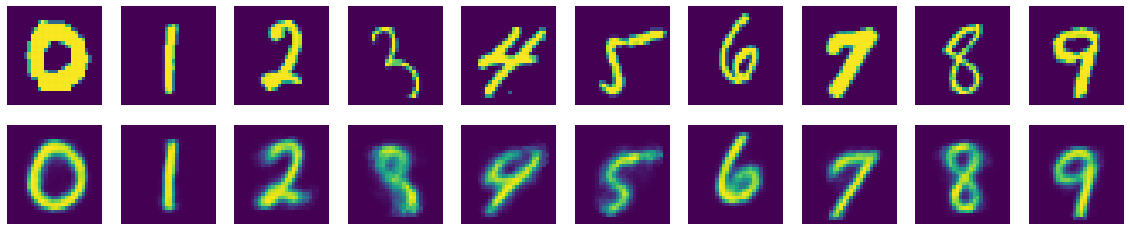

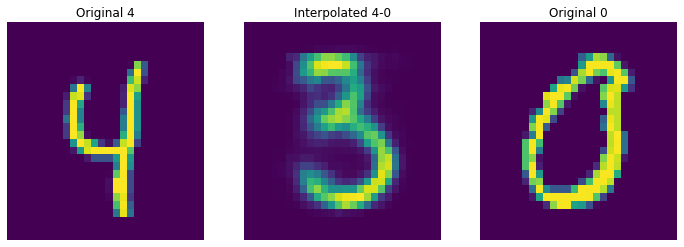

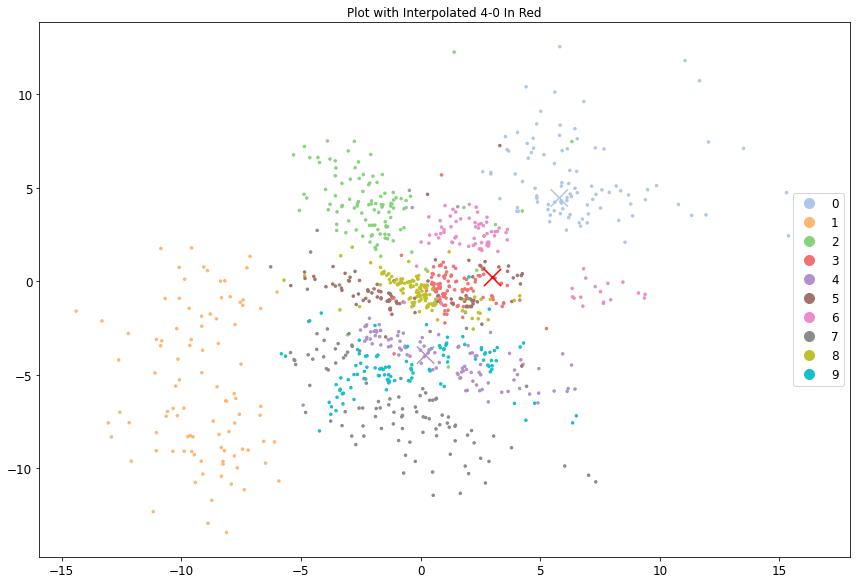

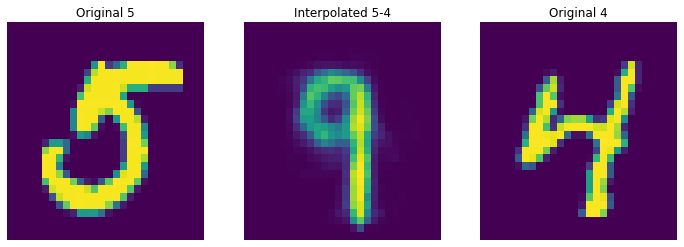

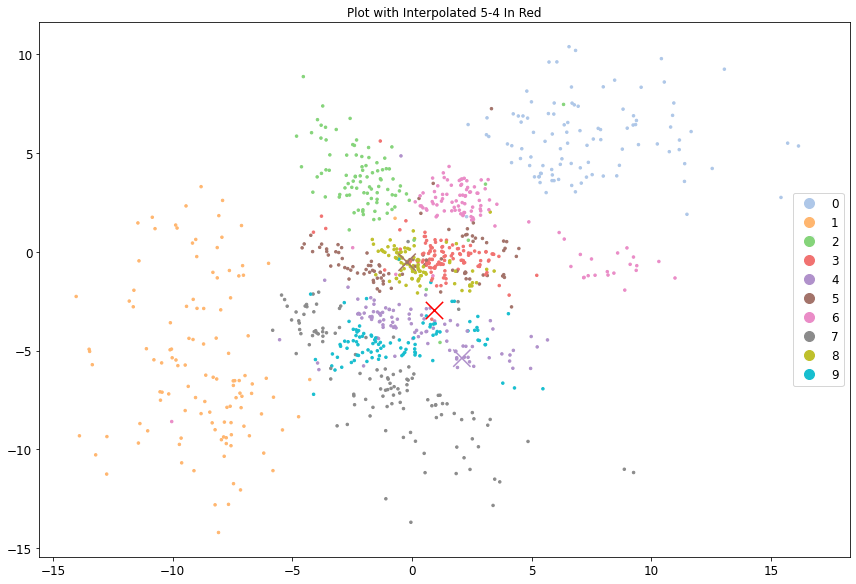

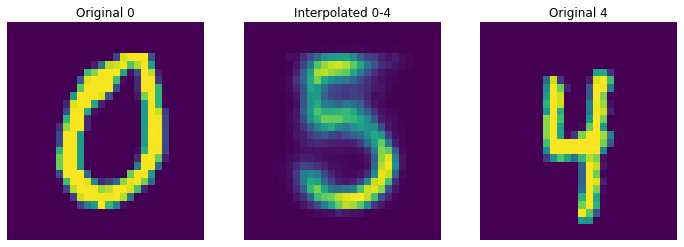

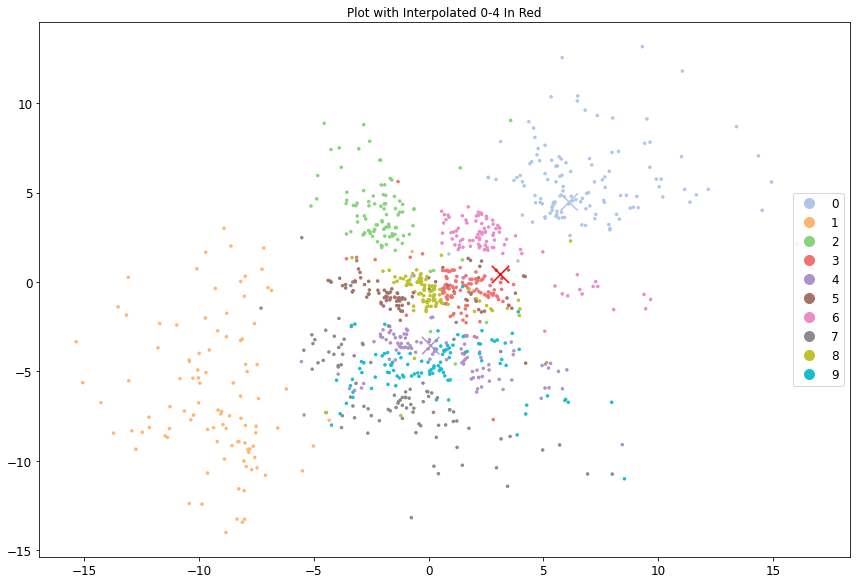

In [ ]:
model = Autoencoder()
model.load_state_dict(torch.load('/content/drive/MyDrive/ColabNotebooks/ae_identity.pt'))
model.eval()

display_1000(model)
display_10(model)

for i in range(3):
  interpolate(model)

**Question 3.1.1:** *Do the colors easily separate, or are they all clumped together? Which numbers are frequently embedded close together, and what does this mean?*

**Answer:** 

**Question 3.1.2:** *How realistic were the images you generated by interpolating between points in the latent space? Can you think of a better way to generate images with an autoencoder?*

**Answer:** 


### 3.2 Biological Data: Retinal Bipolar Dataset

In [ ]:
import pandas
import scprep
from sklearn.model_selection import train_test_split
data = pandas.read_pickle('/content/drive/MyDrive/ColabNotebooks/data/retinal-bipolar-data.pickle')
metadata = pandas.read_pickle('/content/drive/MyDrive/ColabNotebooks/data/retinal-bipolar-metadata.pickle')
data_pca = scprep.reduce.pca(data, 1024)

n_samples = 20000
data_sub, metadata_sub = scprep.select.subsample(data_pca, metadata, n=n_samples, seed=1)
data_sub = np.array(data_sub, dtype=np.float32)
metadata_sub = np.array(metadata_sub)

data_train, data_test, meta_train, meta_test = train_test_split(data_sub, metadata_sub,
                                          test_size=0.2, random_state=1, shuffle=True)

batch_size = 100
rbd_train_loader = torch.utils.data.DataLoader(data_train, batch_size, shuffle = True)
rbd_test_loader = torch.utils.data.DataLoader(data_test, batch_size, shuffle = True)

In [ ]:
def train(model, loss_fn, optimizer, train_loader, test_loader):
    """
    This is a standard training loop, which leaves some parts to be filled in.
    INPUT:
    :param model: an untrained pytorch model
    :param loss_fn: e.g. Cross Entropy loss of Mean Squared Error.
    :param optimizer: the model optimizer, initialized with a learning rate.
    :param training_set: The training data, in a dataloader for easy iteration.
    :param test_loader: The testing data, in a dataloader for easy iteration.
    """
    num_epochs = 100 # obviously, this is too many. I don't know what this author was thinking.
    for epoch in range(num_epochs):
        # loop through each data point in the training set
        for data in train_loader:

            # run the model on the data
            model_input = data.to(device)
            out = model(model_input)

            # Calculate the loss
            loss = loss_fn(out, model_input)

            # Find the gradients of our loss via backpropogation
            loss.backward()

            # Adjust accordingly with the optimizer
            optimizer.step()
            optimizer.zero_grad()

        # Give status reports every 10 epochs
        if (epoch + 1) % 10==0:
            print(f" EPOCH {epoch+1}. Progress: {(epoch+1)/num_epochs*100}%. ")
            print(f" Train loss: {evaluate(model,train_loader)}. Test loss: {evaluate(model,test_loader)}")

def evaluate(model, evaluation_set):
    """
    Evaluates the given model on the given dataset.
    Returns the MSE loss of the output and original input
    """
    total_loss = 0
    total_samples = 0

    with torch.no_grad():
        for data in evaluation_set:

            model_input = data.to(device)
            out = model(model_input)

            total_samples += data.shape[0]
            total_loss += loss_fn(out, model_input)*data.shape[0]

    mean_loss = 1.0 * total_loss / total_samples
    return mean_loss
            
model = Autoencoder(sizes=[1024, 512, 256, 128, 2], post_activation = nn.Identity())
model = model.to(device)
Adam = torch.optim.Adam(model.parameters(), lr = 1e-3)
loss_fn = torch.nn.MSELoss()

train(model, loss_fn, Adam, rbd_train_loader, rbd_test_loader)
torch.save(model.state_dict(), '/content/drive/MyDrive/ColabNotebooks/ae_bipolar.pt')

 EPOCH 10. Progress: 10.0%. 
 Train loss: 2.9391303062438965. Test loss: 2.9613189697265625
 EPOCH 20. Progress: 20.0%. 
 Train loss: 2.9032368659973145. Test loss: 2.932337522506714
 EPOCH 30. Progress: 30.0%. 
 Train loss: 2.8874735832214355. Test loss: 2.927443027496338
 EPOCH 40. Progress: 40.0%. 
 Train loss: 2.875368595123291. Test loss: 2.9199588298797607
 EPOCH 50. Progress: 50.0%. 
 Train loss: 2.8675856590270996. Test loss: 2.9194681644439697
 EPOCH 60. Progress: 60.0%. 
 Train loss: 2.8624868392944336. Test loss: 2.919577121734619
 EPOCH 70. Progress: 70.0%. 
 Train loss: 2.868588924407959. Test loss: 2.9246015548706055
 EPOCH 80. Progress: 80.0%. 
 Train loss: 2.8567006587982178. Test loss: 2.922710657119751
 EPOCH 90. Progress: 90.0%. 
 Train loss: 2.8551230430603027. Test loss: 2.9256434440612793
 EPOCH 100. Progress: 100.0%. 
 Train loss: 2.8623411655426025. Test loss: 2.929213762283325


Text(0.5, 1.0, 'Embedding Layer of Retinal Bipolar Autoencoder for 2000 Cases')

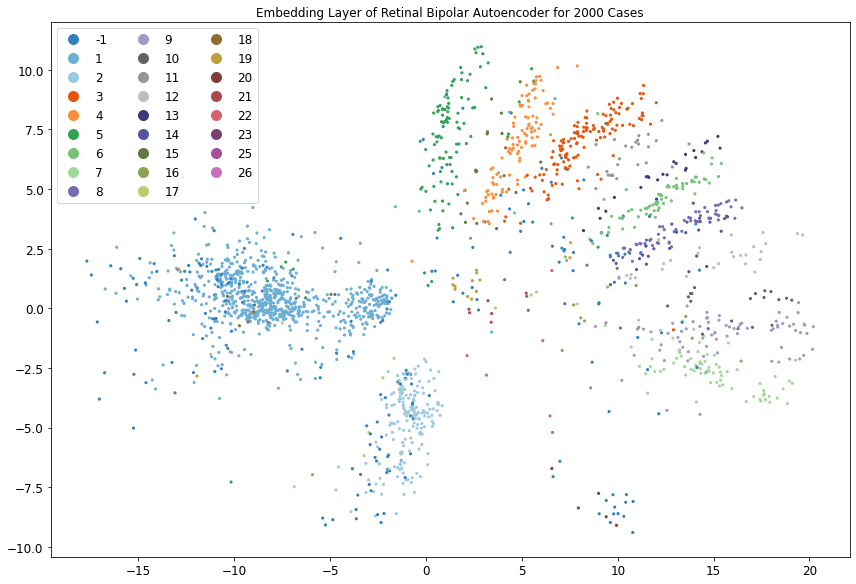

In [ ]:
# Modification of display_1000 code above
model = Autoencoder(sizes=[1024, 512, 256, 128, 2], post_activation = nn.Identity())
model.load_state_dict(torch.load('/content/drive/MyDrive/ColabNotebooks/ae_bipolar.pt'))
model.eval()

all_outs = np.empty((0, 2))
all_targets = []
total_displayed = 0
for i in range(20):
  model_input = torch.tensor(data_test[100*i:100*(i+1), :])
  targets = meta_test[100*i:100*(i+1), 0]
  out = model.encode(model_input).detach().numpy()

  all_outs = np.vstack((all_outs, out))
  all_targets.extend(list(map(int, targets)))
  
  total_displayed += targets.shape[0]

ax = scprep.plot.scatter2d(all_outs, c = all_targets, legend = True, discrete=True,
                      figsize=(12, 8), cmap=scprep.plot.colors.tab30())
ax.set_title(f"Embedding Layer of Retinal Bipolar Autoencoder for {total_displayed} Cases")

**Question 3.2.1:** *How many clusters are visible in the embedding? Do they correspond to the cluster labels?*

**Answer:** 


## 4 Generative Models

### 4.1 The Variational Autoencoder

In [46]:
%cd /content/drive/MyDrive/ColabNotebooks
!python code/vae.py --epochs 100 --log-interval 500

/content/drive/MyDrive/ColabNotebooks
Train Epoch: 1 [0/60000 (0%)]	Loss: 185.038010
====> Epoch: 1 Average loss: 45.1896
====> Test set loss: 36.3585
Train Epoch: 2 [0/60000 (0%)]	Loss: 34.148956
====> Epoch: 2 Average loss: 34.9674
====> Test set loss: 33.4418
Train Epoch: 3 [0/60000 (0%)]	Loss: 33.405102
====> Epoch: 3 Average loss: 33.1410
====> Test set loss: 32.2883
Train Epoch: 4 [0/60000 (0%)]	Loss: 32.802277
====> Epoch: 4 Average loss: 32.2361
====> Test set loss: 31.5511
Train Epoch: 5 [0/60000 (0%)]	Loss: 32.284492
====> Epoch: 5 Average loss: 31.7202
====> Test set loss: 31.2097
Train Epoch: 6 [0/60000 (0%)]	Loss: 32.989441
====> Epoch: 6 Average loss: 31.3635
====> Test set loss: 30.8546
Train Epoch: 7 [0/60000 (0%)]	Loss: 30.950377
====> Epoch: 7 Average loss: 31.0903
====> Test set loss: 30.8190
Train Epoch: 8 [0/60000 (0%)]	Loss: 31.083160
====> Epoch: 8 Average loss: 30.8980
====> Test set loss: 30.5422
Train Epoch: 9 [0/60000 (0%)]	Loss: 31.747532
====> Epoch: 9 Aver

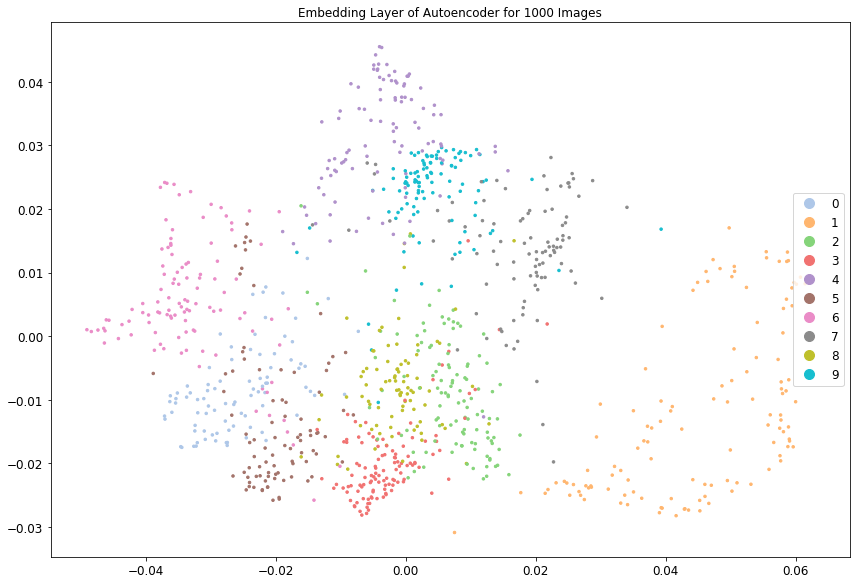

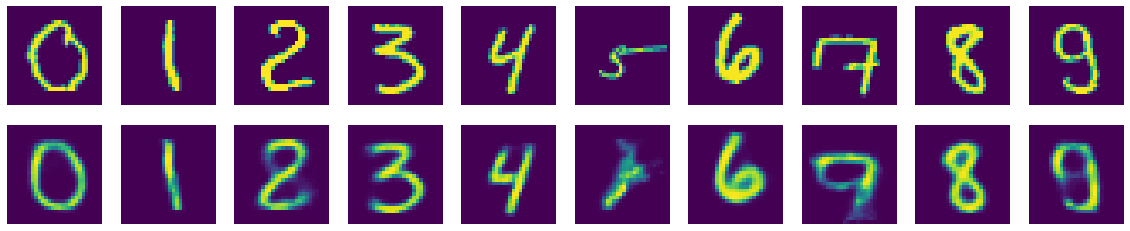

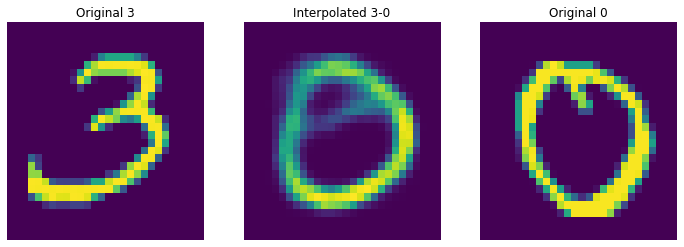

/usr/local/lib/python3.6/dist-packages/phate/phate.py:881: RuntimeWarning: Pre-fit PHATE should not be used to transform a new data matrix. Please fit PHATE to the new data by running 'fit' with the new data.
  RuntimeWarning,


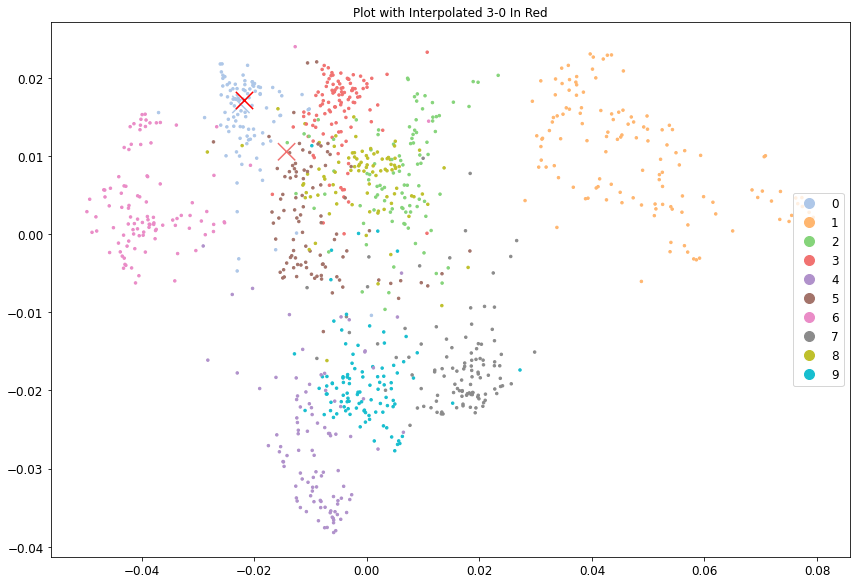

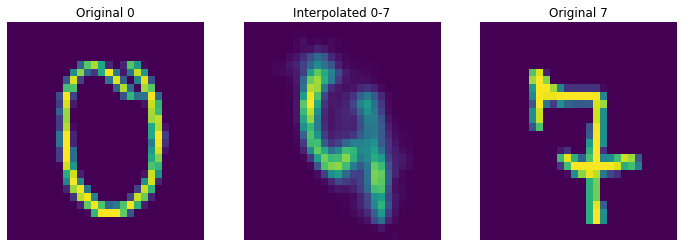

/usr/local/lib/python3.6/dist-packages/phate/phate.py:881: RuntimeWarning: Pre-fit PHATE should not be used to transform a new data matrix. Please fit PHATE to the new data by running 'fit' with the new data.
  RuntimeWarning,


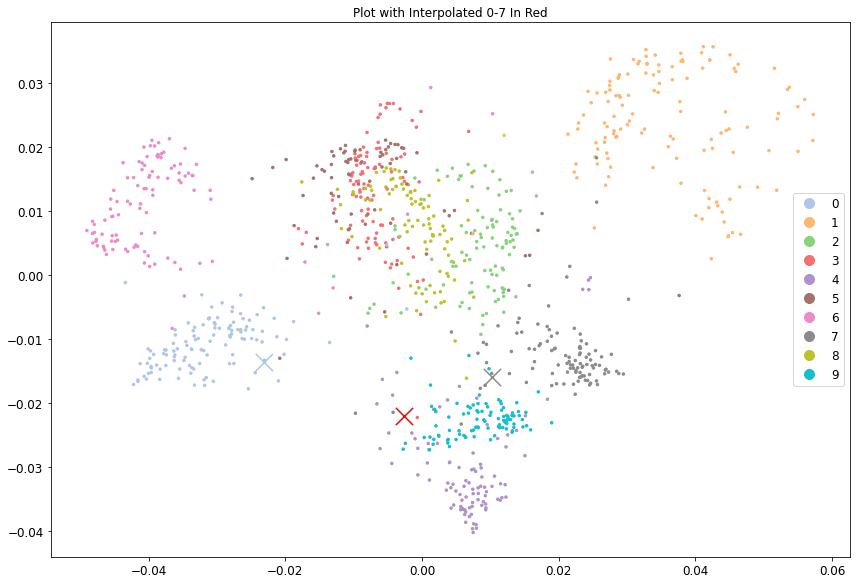

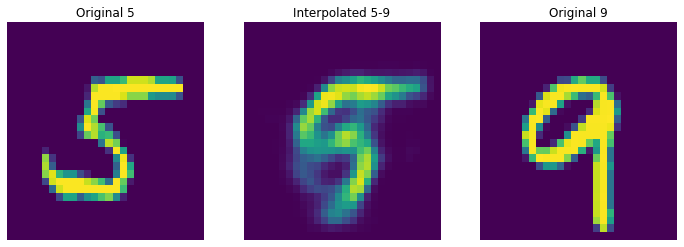

/usr/local/lib/python3.6/dist-packages/phate/phate.py:881: RuntimeWarning: Pre-fit PHATE should not be used to transform a new data matrix. Please fit PHATE to the new data by running 'fit' with the new data.
  RuntimeWarning,


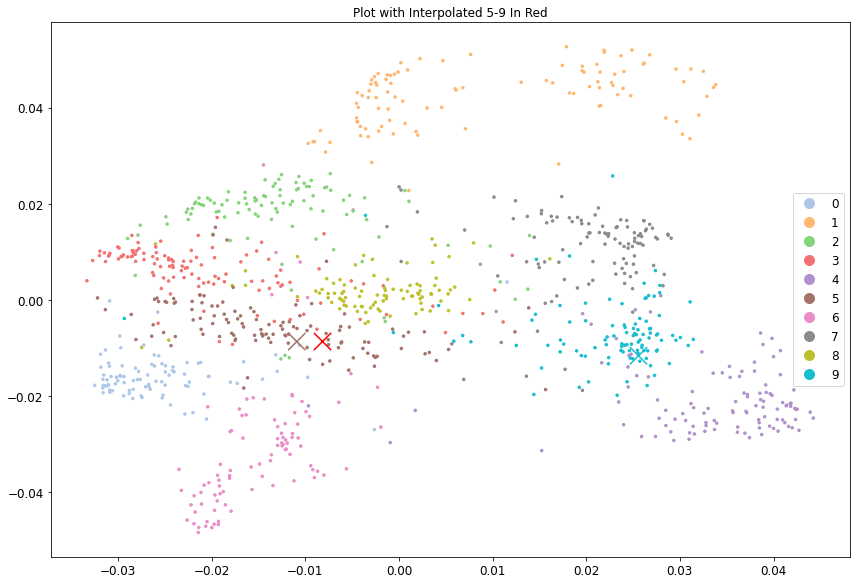

In [47]:
model = torch.load('/content/drive/MyDrive/ColabNotebooks/vae.pt')
model = model.to("cpu")

display_1000(model, out_size = 20)
display_10(model)

for i in range(3):
    interpolate(model)

**Question 4.1.1:** *How does the VAE’s latent space compare to the latent space of your previous autoencoder? Do the generated images have more clarity? Is this most noticeable between or within classes?*

**Answer:** Not really any clearer (because noise) although this model appears to do better at discerning the various digits compared to AE.

**Question 4.1.2:** *In what situations would a VAE be more useful than a vanilla autoencoder, and when would you prefer a vanilla autoencoder to a VAE?*

**Answer:** VAE useful to create new instances (which autoencoders are not as good at). For example, we can't simply draw a random embedding from the AE latent space because we have no restrictions on this latent space. On the other hand, VAE is easier to draw from to create new samples

**Question 4.1.3:** *The distance between embeddings in your first autoencoder provided some measure of the similarity between digits. To what extent is this preserved, or improved, by the VAE?*

**Answer:** 


### 4.2 GANs

In [ ]:
# nz=100
!python code/GAN.py

Epoch 0: mean discriminator loss 0.3963082432746887 // mean generator loss 1.4960644245147705
Epoch 1: mean discriminator loss 0.31417977809906006 // mean generator loss 1.6973217725753784
Epoch 2: mean discriminator loss 0.30743810534477234 // mean generator loss 1.6736215353012085
Epoch 3: mean discriminator loss 0.29308784008026123 // mean generator loss 1.6119202375411987
Epoch 4: mean discriminator loss 0.2723456919193268 // mean generator loss 1.5827842950820923
Epoch 5: mean discriminator loss 0.302641361951828 // mean generator loss 1.4504163265228271
Epoch 6: mean discriminator loss 0.31861451268196106 // mean generator loss 1.3450078964233398
Epoch 7: mean discriminator loss 0.3265911340713501 // mean generator loss 1.3358896970748901
Epoch 8: mean discriminator loss 0.324595183134079 // mean generator loss 1.3386613130569458
Epoch 9: mean discriminator loss 0.31453433632850647 // mean generator loss 1.3653758764266968
Epoch 10: mean discriminator loss 0.30280208587646484 // 

In [ ]:
# nz=25
!python code/GAN.py

Epoch 0: mean discriminator loss 0.4289831519126892 // mean generator loss 1.4224261045455933
Epoch 1: mean discriminator loss 0.38948744535446167 // mean generator loss 1.4830061197280884
Epoch 2: mean discriminator loss 0.33901429176330566 // mean generator loss 1.4941326379776
Epoch 3: mean discriminator loss 0.30918049812316895 // mean generator loss 1.5174927711486816
Epoch 4: mean discriminator loss 0.3451070189476013 // mean generator loss 1.3223142623901367
Epoch 5: mean discriminator loss 0.35682201385498047 // mean generator loss 1.2649003267288208
Epoch 6: mean discriminator loss 0.34560438990592957 // mean generator loss 1.2531505823135376
Epoch 7: mean discriminator loss 0.34246331453323364 // mean generator loss 1.2490540742874146
Epoch 8: mean discriminator loss 0.33268243074417114 // mean generator loss 1.2941964864730835
Epoch 9: mean discriminator loss 0.32107803225517273 // mean generator loss 1.3215296268463135
Epoch 10: mean discriminator loss 0.3104863464832306 //

Counts of 1000 Classififed Numbers: {0: 638, 1: 0, 2: 14, 3: 150, 4: 2, 5: 64, 6: 19, 7: 3, 8: 98, 9: 12}
20 Random Numbers


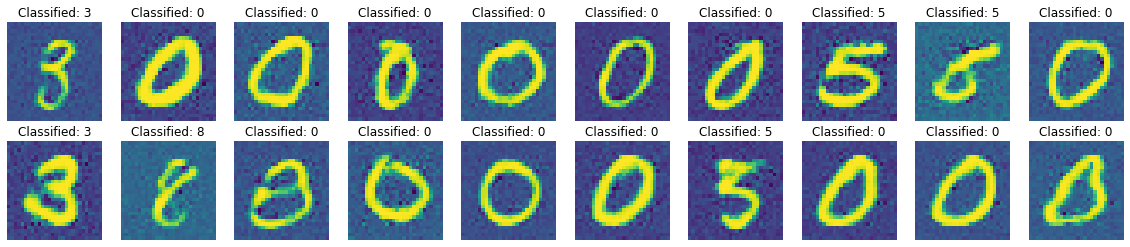

2 of Each Number Generated


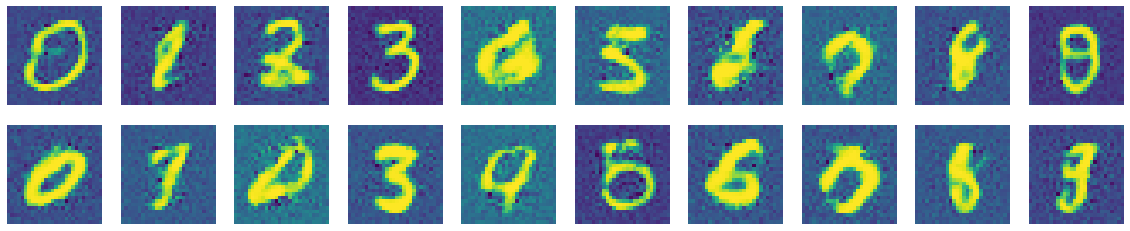

In [23]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz # the dimension of the random noise used to seed the Generator
        self.main = nn.Sequential( # nn.sequential is a handy way of combining multiple layers.
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

# Generator with nz=100
generator = torch.load('/content/drive/MyDrive/ColabNotebooks/gan_2.pt')
generator.eval()

# Best classifier from part 2 (ReLU non-linearity)
classifier = FeedForwardNet(pre_activation = nn.ReLU())
classifier.load_state_dict(torch.load('/content/drive/MyDrive/ColabNotebooks/ff_relu.pt',
                                      map_location=torch.device('cpu')))

torch.manual_seed(2)
counts = torch.zeros(10)
for i in range(10):
    fake_data = generator(torch.randn(100, 100)).reshape(-1, 784)
    labels = classifier(fake_data).argmax(dim=1)
    out, count = torch.unique(labels, sorted=True, return_counts=True)
    for i, label in enumerate(out):
        counts[label] += count[i]

count_dict = {}
for i in range(10):
    count_dict[i] = int(counts[i])
print("Counts of 1000 Classififed Numbers:", count_dict)

# Modified from display_10 function above
torch.manual_seed(1)
fake_data = generator(torch.randn(20, 100)).reshape(-1, 784)
reshaped = fake_data.reshape(-1, 28, 28).detach().numpy()
labels = classifier(fake_data).argmax(dim=1)

print("20 Random Numbers")
plt.figure(figsize=(20, 4))
for i, label in enumerate(labels):
    ax = plt.subplot(2, 10, i + 1)
    ax.title.set_text(f"Classified: {label}")
    plt.axis('off')
    plt.imshow(reshaped[i, :, :], aspect='auto')
  
plt.show()


print("2 of Each Number Generated")
total_displayed = np.zeros(10)
plt.figure(figsize=(20, 4))
while any(total_displayed < 2):
    fake_data = generator(torch.randn(1000, 100)).reshape(-1, 784)
    reshaped = fake_data.reshape(-1, 28, 28).detach().numpy()
    labels = classifier(fake_data).argmax(dim=1)

    for i, target in enumerate(labels):
        if total_displayed[target] == 0:
            plt.subplot(2, 10, target + 1)
            plt.axis('off')
            plt.imshow(reshaped[i, :, :], aspect='auto')
            total_displayed[target] += 1
        elif total_displayed[target] == 1:
            plt.subplot(2, 10, target + 11)
            plt.axis('off')
            plt.imshow(reshaped[i, :, :], aspect='auto')
            total_displayed[target] += 1


plt.show()

**Question 4.2.1:** *Which generates more realistic images: your GAN, or your VAE? Why do you think this
is?*

**Answer:** 

**Question 4.2.2:** *Does your GAN appear to generate all digits in equal number, or has it specialized in a smaller number of digits? If so, why might this be?*

**Answer:** Not equal. Lots of zeros (kind of makes sense since a lot of numbers, especially those with curves, probably look quite similar to zero). Mode collapse. If we wanted equal distribution, probably want a conditional GAN

not many values withs traight lines


## 5 Information Theory

### 5.1 Simple Distribution

In [10]:
import numpy as np
import time
from sklearn.neighbors import KernelDensity
from scipy.stats import entropy
import cv2

# !pip install pyemd
from pyemd import emd
from scipy.spatial.distance import cdist

for var in [0.5, 1, 2, 4]:
    print("Variance:", var)

    samples_normal = np.random.multivariate_normal((0, 0, 0), var*np.identity(3), 1000)
    min_n, max_n = np.min(samples_normal), np.max(samples_normal)
    samples_unif = np.random.uniform(low = min_n, high = max_n, size = (1000, 3))

    space = np.linspace(-1, 1, 10)
    random_space_samples = np.dstack(np.meshgrid(space, space, space)).reshape(-1, 3)
    shifted_space_samples = random_space_samples - random_space_samples.min()

    begin = time.perf_counter()

    kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(samples_unif)
    probs_unif = np.exp(kde.score_samples(random_space_samples))

    kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(samples_normal)
    probs_normal = np.exp(kde.score_samples(random_space_samples))

    dist = entropy(probs_unif, probs_normal)

    print(f" - KL Divergence: dist = {dist} && time = {time.perf_counter() - begin}")


    begin = time.perf_counter()

    kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(samples_unif)
    probs_unif = np.exp(kde.score_samples(random_space_samples))

    kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(samples_normal)
    probs_normal = np.exp(kde.score_samples(random_space_samples))

    distance_matrix = cdist(random_space_samples, random_space_samples)
    dist = emd(probs_unif, probs_normal, distance_matrix)

    print(f" - EMD: dist = {dist} && time = {time.perf_counter() - begin}")


    begin = time.perf_counter()

    dist = mmd(samples_unif, samples_normal, kernel_fn = kernel)

    print(f" - MMD: dist = {dist} && time = {time.perf_counter() - begin}")

Variance: 0.5
 - KL Divergence: dist = 0.14670504694945755 && time = 0.18520544600050926
 - EMD: dist = 158.66448574954055 && time = 0.33318250499996793
 - MMD: dist = 0.07518230913327874 && time = 0.07906796499992197
Variance: 1
 - KL Divergence: dist = 0.049236705403228775 && time = 0.1870747279999705
 - EMD: dist = 90.70489281075598 && time = 0.3080689489997894
 - MMD: dist = 0.028827735123625402 && time = 0.07752726600028836
Variance: 2
 - KL Divergence: dist = 0.2593963036742043 && time = 0.17661490000045887
 - EMD: dist = 47.747569184233306 && time = 0.3179734509994887
 - MMD: dist = 0.012421204712772808 && time = 0.08347262000006594
Variance: 4
 - KL Divergence: dist = 0.1940187874080787 && time = 0.16791992199978267
 - EMD: dist = 19.699180311786428 && time = 0.29306238800018036
 - MMD: dist = 0.004631832557261253 && time = 0.07704812999963906


**Question 5.1.1:** *Based on the above measures alone, which divergence seems most accurate?*

**Answer:** 


### 5.2 MNIST Sample Distributions

In [13]:
mnist_1 = mnist_test.data[:1000, ]
mnist_2 = mnist_test.data[1000:2000, ]

mnist_1, mnist_2, _ = torch.utils.data.random_split(mnist_test, [1000, 1000, 8000])

loader_1 = torch.utils.data.DataLoader(mnist_1, 1000, shuffle = True)
loader_2 = torch.utils.data.DataLoader(mnist_2, 1000, shuffle = True)

for data, targets in loader_1:
    data_1_og = data.reshape(-1, 784).numpy()

for data, targets in loader_2:
    data_2_og = data.reshape(-1, 784).numpy()

# Tried using 8 dimensions but not enough RAM (Kincaid said it was okay)
nc = 4
data_1 = scprep.reduce.pca(data_1_og, n_components=nc)
data_2 = scprep.reduce.pca(data_2_og, n_components=nc)

min_1, max_1 = data_1.min(), data_1.max()
space = np.linspace(min_1, max_1, 6)
random_space_samples = np.dstack(np.meshgrid(*([space]*nc))).reshape(-1, nc)

begin = time.perf_counter()

kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(data_1)
probs_1 = np.exp(kde.score_samples(random_space_samples))

kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(data_2)
probs_2 = np.exp(kde.score_samples(random_space_samples))

dist = entropy(probs_1, probs_2)

print(f" - KL Divergence: dist = {dist} && time = {time.perf_counter() - begin}")


begin = time.perf_counter()

kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(data_1)
probs_1 = np.exp(kde.score_samples(random_space_samples))

kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(data_2)
probs_2 = np.exp(kde.score_samples(random_space_samples))

distance_matrix = cdist(random_space_samples, random_space_samples)
dist = emd(probs_1, probs_2, distance_matrix)

print(f" - EMD: dist = {dist} && time = {time.perf_counter() - begin}")


begin = time.perf_counter()

dist = mmd(data_1, data_2, kernel_fn = kernel)

print(f" - MMD: dist = {dist} && time = {time.perf_counter() - begin}")

 - KL Divergence: dist = 0.14935128971799774 && time = 0.15531815199983612
 - EMD: dist = 1.0138824703152054 && time = 0.5614113880001241
 - MMD: dist = 0.0027639240734857783 && time = 0.07363484799998332


### 5.3 The GAN Distribution

In [15]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz # the dimension of the random noise used to seed the Generator
        self.main = nn.Sequential( # nn.sequential is a handy way of combining multiple layers.
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

# Generator with nz=25
generator = torch.load('/content/drive/MyDrive/ColabNotebooks/gan.pt', map_location=torch.device('cpu'))
generator.eval()

# Modified from display_10 function above
torch.manual_seed(1)
fake_data = generator(torch.randn(1000, 25)).reshape(-1, 784).detach().numpy()

# Reduce Dimensions
fake_data = scprep.reduce.pca(fake_data, n_components=nc)

# Calculate divergences
begin = time.perf_counter()

kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(data_1)
probs_1 = np.exp(kde.score_samples(random_space_samples))

kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(fake_data)
probs_2 = np.exp(kde.score_samples(random_space_samples))

dist = entropy(probs_1, probs_2)

print(f" - KL Divergence: dist = {dist} && time = {time.perf_counter() - begin}")


begin = time.perf_counter()

kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(data_1)
probs_1 = np.exp(kde.score_samples(random_space_samples))

kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(fake_data)
probs_2 = np.exp(kde.score_samples(random_space_samples))

distance_matrix = cdist(random_space_samples, random_space_samples)
dist = emd(probs_1, probs_2, distance_matrix)

print(f" - EMD: dist = {dist} && time = {time.perf_counter() - begin}")


begin = time.perf_counter()

dist = mmd(data_1, fake_data, kernel_fn = kernel)

print(f" - MMD: dist = {dist} && time = {time.perf_counter() - begin}")

 - KL Divergence: dist = 2.108193038027787 && time = 0.1660773639996478
 - EMD: dist = 1.5570548703870426 && time = 1.505367965000005
 - MMD: dist = 0.0018521580593959107 && time = 0.0738519230003476


**Question 5.3.1:** *Which divergence or distance showed the greatest discrepancy between the comparison between real MNIST data and the comparison with the GAN?*

**Answer:** "My suspicion is that KL divergence is generally clueless, and the GAN distribution is actually very close to the MNIST distribution -- or at least, is within the range of variation between different MNIST samples." - Kincaid

likely depends on what the GAN is doing

**Question 5.3.2:** *Which of these information measures would you recommend for judging a GAN’s output? Why?*

**Answer:** 

**Question 5.3.3:** *How do the runtimes of these measures compare?*

**Answer:** 
